<a href="https://colab.research.google.com/github/MitchDeWe/Model_creation/blob/main/Movinet_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is code generating and training a custom model from the tutorial outlined at https://github.com/tensorflow/models/blob/master/official/projects/movinet/movinet_streaming_model_training_and_inference.ipynb 

In [1]:
!pip install -U -q "tf-models-official"


# Install the mediapy package for visualizing images/videos.
# See https://github.com/google/mediapy
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy remotezip
!pip install -U -q git+https://github.com/tensorflow/docs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 18.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 105.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 74.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.

Import all necessary libraries

In [2]:
import os
import tqdm
import random
import pathlib
import imageio
import itertools
import collections

import cv2
import numpy as np
import zipfile as zp
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tensorflow_docs.vis import embed

import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

RuntimeError: ignored

RuntimeError: ignored

Get the MoViNet models to perfrom transfer learning

In [3]:
import functools
from typing import Any, Callable, Mapping, Optional
from absl import logging

import tensorflow_hub as hub

from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model
from official.projects.movinet.tools import export_saved_model


#from official.vision.configs import video_classification as video_classification_configs
#from official.vision.tasks import video_classification


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


The following set of code is used to get the video dataset split it into the format for training validation and testing.

In [4]:
def list_files_per_class(zip_dir):
  """ List the files in each class of the dataset given the directory.

    Args:
      zip_dire: Directory from which the files can be extracted from.

    Returns:
      List of files in each of the classes.
  """
  files = []
  with zp.ZipFile(zip_dir) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """ Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in dataset

    Returns:
      Class that the file belongs to.
  """
  return fname.split('/')[-2]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder  

def download_from_zip(zip_dir, to_dir, file_names):
  """
    Download the contents of the zip file from the zip.

    Args:
      zip_dir: Zip directory containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with zp.ZipFile(zip_dir) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def download_split_dataset(zip_dir, num_classes, splits, download_dir):
  """
    Get the dataset from the directory and split the data then save it to download dir

    Args:
      zip_dir: Zip directory containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_dir)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)
  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_dir, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

Code to essentially format frames and from the videos in the format necessary for training.

In [5]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (172,172), frame_step = 7):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')


class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [6]:
DIR = 'drive/MyDrive/gesture_dataset_cut.zip'
download_dir = pathlib.Path('./gesture_set/')
subset_paths = download_split_dataset(DIR,
                        num_classes = 7,
                        splits = {"train": 70, "val": 15, "test": 15},
                        download_dir = download_dir)

train :


100%|██████████| 490/490 [00:03<00:00, 148.62it/s]


val :


100%|██████████| 105/105 [00:00<00:00, 692.88it/s]


test :


100%|██████████| 105/105 [00:00<00:00, 211.73it/s]


Prepare the datasets

In [7]:

batch_size = 4
num_frames = 10

CLASSES = sorted(os.listdir('./gesture_set/train'))

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], num_frames, training = True),
                                          output_signature = output_signature)
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], num_frames),
                                          output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], num_frames),
                                         output_signature = output_signature)
test_ds = test_ds.batch(batch_size)

In [8]:
for frames, labels in train_ds.take(1):
  print(f"Shape: {frames.shape}")
  print(f"Label: {labels.shape}")

Shape: (4, 10, 172, 172, 3)
Label: (4,)


Construct the backbone

In [9]:
model_id = 'a0'
use_positional_encoding = model_id in {'a3', 'a4', 'a5'}
resolution = 172

backbone = movinet.Movinet(
    model_id=model_id,
    causal=True,
    conv_type='2plus1d',
    se_type='2plus3d',
    activation='hard_swish',
    gating_activation='hard_sigmoid',
    use_positional_encoding=use_positional_encoding,
    use_external_states=False,
)

Construct the model and load the pre trained weights

In [10]:

# Note: this is a temporary model constructed for the
# purpose of loading the pre-trained checkpoint. Only
# the backbone will be used to build the custom classifier.

model = movinet_model.MovinetClassifier(
    backbone,
    num_classes=600,
    output_states=True)

# Create your example input here.
# Refer to the paper for recommended input shapes.
inputs = tf.ones([1, 13, 172, 172, 3])

# [Optional] Build the model and load a pretrained checkpoint.
model.build(inputs.shape)

# Extract pretrained weights
!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_stream.tar.gz -O movinet_a0_stream.tar.gz -q
!tar -xvf movinet_a0_stream.tar.gz

checkpoint_dir = 'movinet_a0_stream'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

movinet_a0_stream/
movinet_a0_stream/ckpt-1.data-00000-of-00001
movinet_a0_stream/ckpt-1.index
movinet_a0_stream/checkpoint


set up distribution in google colab

In [11]:
# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  distribution_strategy = tf.distribute.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  distribution_strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  distribution_strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  distribution_strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

print("Number of accelerators: ", distribution_strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


Consttuct custom classifier

In [12]:

def build_classifier(batch_size, num_frames, resolution, backbone, num_classes):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes)
  model.build([batch_size, num_frames, resolution, resolution, 3])

  return model

# Construct loss, optimizer and compile the model
with distribution_strategy.scope():
  model = build_classifier(batch_size, num_frames, resolution, backbone, 7)
  loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
  model.compile(loss=loss_obj, optimizer=optimizer, metrics=['accuracy'])

Create callback for storing checkpoints

In [13]:

checkpoint_path = "trained_model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

train the model

In [14]:
results = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=5,
                    validation_freq=1,
                    verbose=1,
                    callbacks=[cp_callback])

Epoch 1/5
    122/Unknown - 126s 320ms/step - loss: 1.7736 - accuracy: 0.2701
Epoch 1: saving model to trained_model/cp.ckpt
122/122 [==============================] - 141s 442ms/step - loss: 1.7736 - accuracy: 0.2701 - val_loss: 1.9108 - val_accuracy: 0.3846
Epoch 2/5
122/122 [==============================] - ETA: 0s - loss: 1.1949 - accuracy: 0.5196
Epoch 2: saving model to trained_model/cp.ckpt
122/122 [==============================] - 45s 370ms/step - loss: 1.1949 - accuracy: 0.5196 - val_loss: 0.9371 - val_accuracy: 0.6635
Epoch 3/5
122/122 [==============================] - ETA: 0s - loss: 0.7826 - accuracy: 0.7237
Epoch 3: saving model to trained_model/cp.ckpt
122/122 [==============================] - 46s 373ms/step - loss: 0.7826 - accuracy: 0.7237 - val_loss: 0.7619 - val_accuracy: 0.7212
Epoch 4/5
122/122 [==============================] - ETA: 0s - loss: 0.4817 - accuracy: 0.8309
Epoch 4: saving model to trained_model/cp.ckpt
122/122 [==============================] - 45s

In [15]:
model.evaluate(test_ds)

26/26 [==============================] - 6s 248ms/step - loss: 0.4028 - accuracy: 0.8750


[0.4027596116065979, 0.875]

In [16]:
def get_actual_predicted_labels(dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted
     

In [17]:
def plot_confusion_matrix(actual, predicted, labels, ds_type, matrix_name):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(30, 30)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)
  plt.savefig(matrix_name)
  plt.show()

In [18]:

fg = FrameGenerator(subset_paths['train'], num_frames, training = True)
label_names = list(fg.class_ids_for_name.keys())

In [19]:
actual, predicted = get_actual_predicted_labels(test_ds)


26/26 [==============================] - 14s 263ms/step


In [21]:
plot_confusion_matrix(actual, predicted, label_names, 'test','TF gesture model Matrix')

reconstruct using external states

In [ ]:
model_id = 'a0'
use_positional_encoding = model_id in {'a3', 'a4', 'a5'}
resolution = 172

# Create backbone and model.
backbone = movinet.Movinet(
    model_id=model_id,
    causal=True,
    conv_type='2plus1d',
    se_type='2plus3d',
    activation='hard_swish',
    gating_activation='hard_sigmoid',
    use_positional_encoding=use_positional_encoding,
    use_external_states=True,
)

model = movinet_model.MovinetClassifier(
    backbone,
    num_classes=7,
    output_states=True)

# Create your example input here.
# Refer to the paper for recommended input shapes.
inputs = tf.ones([1, 13, 172, 172, 3])

# [Optional] Build the model and load a pretrained checkpoint.
model.build(inputs.shape)

# Load weights from the checkpoint to the rebuilt model
checkpoint_dir = 'trained_model'
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [23]:

def get_top_k(probs, k=5, label_map=CLASSES):
  """Outputs the top k model labels and probabilities on the given video."""
  top_predictions = tf.argsort(probs, axis=-1, direction='DESCENDING')[:k]
  top_labels = tf.gather(label_map, top_predictions, axis=-1)
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]
  top_probs = tf.gather(probs, top_predictions, axis=-1).numpy()
  return tuple(zip(top_labels, top_probs))


FlatHand_Down 1.0
Draw_Circle 1.1796243e-14
Swipe_Left 3.0440643e-15
Swipe_Right 1.774292e-17
BothHands_Up 5.358186e-18



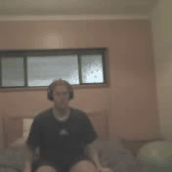

In [24]:
# Create initial states for the stream model
init_states_fn = model.init_states
init_states = init_states_fn(tf.shape(tf.ones(shape=[1, 1, 172, 172, 3])))

all_logits = []

# To run on a video, pass in one frame at a time
states = init_states
for frames, label in test_ds.take(1):
  for clip in frames[0]:
    # Input shape: [1, 1, 172, 172, 3]
    clip = tf.expand_dims(tf.expand_dims(clip, axis=0), axis=0)
    logits, states = model.predict({**states, 'image': clip}, verbose=0)
    all_logits.append(logits)

logits = tf.concat(all_logits, 0)
probs = tf.nn.softmax(logits)

final_probs = probs[-1]
top_k = get_top_k(final_probs)
print()
for label, prob in top_k:
  print(label, prob)

frames, label = list(test_ds.take(1))[0]
to_gif(frames[0].numpy())

Export to saved model

In [25]:
saved_model_dir = 'model'
tflite_filename = 'model.tflite'
input_shape = [1, 1, 172, 172, 3]

# Convert to saved model
export_saved_model.export_saved_model(
    model=model,
    input_shape=input_shape,
    export_path=saved_model_dir,
    causal=True,
    bundle_input_init_states_fn=False)

have a 2nd saved model with the states for creating the representative dataset

In [26]:
saved_model_with_states_dir = 'model_states'
tflite_states_filename = 'model_states.tflite'
input_shape = [1, 1, 172, 172, 3]

# Convert to saved model
export_saved_model.export_saved_model(
    model=model,
    input_shape=input_shape,
    export_path=saved_model_with_states_dir,
    causal=True,
    bundle_input_init_states_fn=True)

Create representative dataset for quantization

In [27]:
def stateful_representative_dataset_generator(
    model: tf.keras.Model,
    dataset_iter: Any,
    init_states: Mapping[str, tf.Tensor],
    save_dataset_to_tfrecords: bool = False,
    max_saved_files: int = 100,
    output_dataset_dir: Optional[str] = None,
    num_samples_per_video: int = 3,
    num_calibration_videos: int = 100):
  """Generates sample input data with states.

  Args:
    model: the inference keras model.
    dataset_iter: the dataset source.
    init_states: the initial states for the model.
    save_dataset_to_tfrecords: whether to save the representative dataset to
      tfrecords on disk.
    max_saved_files: the max number of saved tfrecords files.
    output_dataset_dir: the directory to store the saved tfrecords.
    num_samples_per_video: number of randomly sampled frames per video.
    num_calibration_videos: number of calibration videos to run.

  Yields:
    A dictionary of model inputs.
  """
  counter = 0
  for i in range(num_calibration_videos):
    if i % 100 == 0:
      logging.info('Reading representative dateset id %d.', i)

    example_input, example_label = next(dataset_iter)
    groundtruth_label_id = tf.argmax(example_label, axis=-1)
    input_states = init_states
    # split video into frames along the temporal dimension.
    frames = tf.split(example_input, example_input.shape[1], axis=1)

    random_indices = np.random.randint(
        low=1, high=len(frames), size=num_samples_per_video)
    # always include the first frame
    random_indices[0] = 0
    random_indices = set(random_indices)

    for frame_index, frame in enumerate(frames):
      predictions, output_states = model({'image': frame, **input_states})
      if frame_index in random_indices:
        #if save_dataset_to_tfrecords and counter < max_saved_files:
         # save_to_tfrecord(
             # input_frame=frame,
             # input_states=input_states,
             # frame_index=frame_index,
             #predictions=predictions,
              #output_states=output_states,
              #groundtruth_label_id=groundtruth_label_id,
              #output_dataset_dir=output_dataset_dir,
              #file_index=counter)
        yield {'image': frame, **input_states}
        counter += 1

      # update states for the next inference step
      input_states = output_states

Convert to tensorflow lite model

In [28]:
fr_num = 13
batach_s = 1
re_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], fr_num, training = False),
                                          output_signature = output_signature)
re_ds = re_ds.batch(batach_s)

dataset_iter = iter(re_ds)
for frames, labels in re_ds.take(1):
  print(f"Shape: {frames.shape}")
  print(f"Label: {labels.shape}")

Shape: (1, 13, 172, 172, 3)
Label: (1,)


In [ ]:


# Load model
encoder = hub.KerasLayer(saved_model_with_states_dir, trainable=False)
inputs_q = tf.keras.layers.Input(
    shape=[1, 172, 172, 3],
    dtype=tf.float32,
    name='image')

# Define the state inputs, which is a dict that maps state names to tensors.
init_states_fn = encoder.resolved_object.signatures['init_states']
state_shapes = {
    name: ([s if s > 0 else None for s in state.shape], state.dtype)
    for name, state in init_states_fn(
        tf.constant([1, 1, 172, 172, 3])).items()
}
states_input = {
    name: tf.keras.Input(shape[1:], dtype=dtype, name=name)
    for name, (shape, dtype) in state_shapes.items()
}

# The inputs to the model are the states and the video
inputs_q = {**states_input, 'image': inputs_q}
outputs = encoder(inputs_q)
model_q = tf.keras.Model(inputs_q, outputs, name='movinet_stream')
input_shape_q = tf.constant(
    [1, fr_num, 172, 172, 3])

init_states = init_states_fn(input_shape_q)

In [30]:
def quantized_scale(name, state):
  """Scales the named state tensor input for the quantized model."""
  dtype = input_details[name]['dtype']
  scale, zero_point = input_details[name]['quantization']
  if 'frame_count' in name or dtype == np.float32 or scale == 0.0:
    return state
  return np.cast((state / scale + zero_point), dtype)

In [ ]:

representative_dataset = functools.partial(
      stateful_representative_dataset_generator,
      model=model_q,
      dataset_iter=dataset_iter,
      init_states=init_states,
      save_dataset_to_tfrecords=False,
      max_saved_files=100,
      output_dataset_dir=None,
      num_samples_per_video=3,
      num_calibration_videos=100)

#rep_gen = FrameGenerator(subset_paths['test'], fr_num, training = False)
#representative_dataset = 
#the size of this is already appropriate for a representative dataset
#representative_dataset = representative_dataset.batch(1)
# model = tf.saved_model.load(saved_model_dir)
# concrete_func = model.signatures[
#   tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
# concrete_func.inputs[0].set_shape([1, 1, 172, 172, 3])

# converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])


converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8

tflite_model = converter.convert()

with open(tflite_filename, 'wb') as f:
  f.write(tflite_model)





In [32]:
#Create the interpreter and signature runner
interpreter = tf.lite.Interpreter(model_path=tflite_filename)
runner = interpreter.get_signature_runner()
input_details = runner.get_input_details()

init_states = {
    name: tf.zeros(x['shape'], dtype=x['dtype'])
    for name, x in runner.get_input_details().items()
}
del init_states['image']





FlatHand_Down 1.0
Draw_Circle 1.1796243e-14
Swipe_Left 3.0440643e-15
Swipe_Right 1.774292e-17
BothHands_Up 5.358186e-18



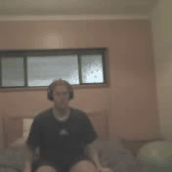

In [33]:

# To run on a video, pass in one frame at a time
states = init_states
for frames, label in re_ds.take(1):
  states = init_states ####
  for clip in frames[0]:
    # Input shape: [1, 1, 172, 172, 3]
    conv_img = tf.image.convert_image_dtype(clip, 'int8')
    outputs = runner(**states, image=conv_img)
    logits = outputs.pop('logits')[0]
    states = outputs

probs = tf.nn.softmax(tf.cast(logits, 'float32'))
op_k = get_top_k(probs)
print()
for label, prob in top_k:
  print(label, prob)
frames, label = list(test_ds.take(1))[0]
to_gif(frames[0].numpy())


